# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb
from importlib import reload
import my_model_selectors
reload(my_model_selectors)

asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [13]:
asl.df.ix[98,5]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 5), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [14]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [15]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-rx', 'grnd-ly', 'grnd-lx' representing differences between hand and nose locations
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [16]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [17]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['JOHN', 'WRITE', 'HOMEWORK', 'IX-1P', 'SEE', 'YESTERDAY', 'IX', 'LOVE', 'MARY', 'CAN', 'GO', 'GO1', 'FUTURE', 'GO2', 'PARTY', 'FUTURE1', 'HIT', 'BLAME', 'FRED', 'FISH', 'WONT', 'EAT', 'BUT', 'CHICKEN', 'VEGETABLE', 'CHINA', 'PEOPLE', 'PREFER', 'BROCCOLI', 'LIKE', 'LEAVE', 'SAY', 'BUY', 'HOUSE', 'KNOW', 'CORN', 'CORN1', 'THINK', 'NOT', 'PAST', 'LIVE', 'CHICAGO', 'CAR', 'SHOULD', 'DECIDE', 'VISIT', 'MOVIE', 'WANT', 'SELL', 'TOMORROW', 'NEXT-WEEK', 'NEW-YORK', 'LAST-WEEK', 'WILL', 'FINISH', 'ANN', 'READ', 'BOOK', 'CHOCOLATE', 'FIND', 'SOMETHING-ONE', 'POSS', 'BROTHER', 'ARRIVE', 'HERE', 'GIVE', 'MAN', 'NEW', 'COAT', 'WOMAN', 'GIVE1', 'HAVE', 'FRANK', 'BREAK-DOWN', 'SEARCH-FOR', 'WHO', 'WHAT', 'LEG', 'FRIEND', 'CANDY', 'BLUE', 'SUE', 'BUY1', 'STOLEN', 'OLD', 'STUDENT', 'VIDEOTAPE', 'BORROW', 'MOTHER', 'POTATO', 'TELL', 'BILL', 'THROW', 'APPLE', 'NAME', 'SHOOT', 'SAY-1P', 'SELF', 'GROUP', 'JANA', 'TOY1', 'MANY', 'TOY', 'ALL', 'BOY', 'TEACHER', 'GIRL', 'BOX', 'GIVE2', 'GIVE3

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [18]:
training.get_all_Xlengths()['CHOCOLATE']

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [19]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [20]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [21]:
from asl_utils import test_std_tryit
# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std=asl.df.groupby('speaker').std()
# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [22]:
# TODO add features for normalized by speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd
features=['right-x', 'right-y', 'left-x', 'left-y']
features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']
for z in zip(features, features_norm):
    asl.df[z[1]]=(asl.df[z[0]]- asl.df['speaker'].map(df_means[z[0]]))/asl.df['speaker'].map(df_std[z[0]])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean   norm-rx  \
video frame                                                              
98    0          113        9      119      -12   164.661438  1.153232   
      1          113        9      119      -12   164.661438  1.153232   
      2          113        9      119      -12   164.661438  1.153232   
      3          113        9      119      -12   164.661438  1.153232   
      4          113        9      119      -12   164.661438  1.153232   

              norm-ry   norm-lx   norm-ly  
video frame                                
98    0      1.663433 -0.891199  0.741835  
      1      1.663433 -0.891199  0.741835  
      2      1.663433 -0.891199  0.741835  
      3      1.663433 -0.891199  0.741835  
      4      1.663433 -0.891199  0.741835

In [23]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']
asl.df['polar-rr']=np.sqrt(np.square(asl.df['right-x']-asl.df['nose-x'])+np.square(asl.df['right-y']-asl.df['nose-y']))
asl.df['polar-rtheta']=np.arctan2(asl.df['right-x']-asl.df['nose-x'], asl.df['right-y']-asl.df['nose-y'])
asl.df['polar-lr']=np.sqrt(np.square(asl.df['left-x']-asl.df['nose-x'])+np.square(asl.df['left-y']-asl.df['nose-y']))
asl.df['polar-ltheta']=np.arctan2(asl.df['left-x']-asl.df['nose-x'], asl.df['left-y']-asl.df['nose-y'])

In [24]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'
features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']
for z in zip(features, features_delta):
    print(z)
    asl.df[z[1]]=0
    asl.df[z[1]][1:]=np.diff(asl.df[z[0]]) 
asl.df.head()

('right-x', 'delta-rx')
('right-y', 'delta-ry')
('left-x', 'delta-lx')
('left-y', 'delta-ly')


C:\ProgramData\Anaconda3\envs\aind\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly    ...      norm-lx   norm-ly  \
video frame                               ...                          
98    0          113        9      119    ...    -0.891199  0.741835   
      1          113        9      119    ...    -0.891199  0.741835   
      2          113        9      119    ...    -0.891199  0.741835   
      3          113        9      119    ...    -0.891199  0.741835   
      4          113        9      119    ...    -0.891199  0.741835   

              polar-rr  polar-rtheta    polar-lr  polar-ltheta  delta-rx  \
video frame                                                                
98    0      113.35784      0.079478  119.603512     -0.100501         0   
      1      113.35784      0.079478  119.603512     -0.100501         0   
      2      113.35784      0.079478  119.603512     -0.100501         0   
      3      113.35784      0.079478  119.603512     -0.100501         0   
      4      113.35784      0.079478  119.603512     -0.100501         0   

             delta-ry  delta-lx  delta-ly  
video frame                                
98    0             0         0         0  
      1             0         0         0  
      2             0         0         0  
      3             0         0         0  
      4             0         0         0  

[5 rows x 24 columns]

In [25]:
max(asl.df['polar-rr'])

189.38056922503955

In [26]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like
# custom features are deltas for polar coordinates; similarly to cartesian
features_custom=['norm-polar-rr', 'norm-polar-rtheta', 'norm-polar-lr', 'norm-polar-ltheta']
asl.df['norm-polar-rr']=np.divide(asl.df['polar-rr']-min(asl.df['polar-rr']), (max(asl.df['polar-rr'])-min(asl.df['polar-rr'])))
asl.df['norm-polar-lr']=np.divide(asl.df['polar-lr']-min(asl.df['polar-lr']), (max(asl.df['polar-lr'])-min(asl.df['polar-lr'])))
asl.df['norm-polar-rtheta']=np.divide(asl.df['polar-rtheta']-min(asl.df['polar-rtheta']), (max(asl.df['polar-rtheta'])-min(asl.df['polar-rtheta'])))
asl.df['norm-polar-ltheta']=np.divide(asl.df['polar-ltheta']-min(asl.df['polar-ltheta']), (max(asl.df['polar-ltheta'])-min(asl.df['polar-ltheta'])))
    
# TODO define a list named 'features_custom' for building the training set

In [27]:
max(asl.df['norm-polar-ltheta'])

1.0

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:** custom features are deltas for polar coordinates; similarly to cartesian coordinate system. Including poral system looked interesting, however it will suffer from the variability in the range of variables. Using delta's hihlights time periods when the hand is moving the most. Therefore, deltas were added as features in the cartesian system. Here I added deltas in polar coordinate system, to see if there will me an improvment over the deltas in the cartesian system.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [2]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

EEEE
ERROR: test_features_delta (__main__.TestFeatures)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-2-4e7516a8b40e>", line 19, in test_features_delta
    sample = (asl.df.ix[98, 0][features_delta]).tolist()
NameError: name 'features_delta' is not defined

ERROR: test_features_ground (__main__.TestFeatures)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-2-4e7516a8b40e>", line 7, in test_features_ground
    sample = (asl.df.ix[98, 1][features_ground]).tolist()
NameError: name 'features_ground' is not defined

ERROR: test_features_norm (__main__.TestFeatures)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-2-4e7516a8b40e>", line 11, in test_features_norm
    sample = (asl.df.ix[98, 1][features_norm]).tolist()
NameError: name 'features_norm' is n

<unittest.runner.TextTestResult run=4 errors=4 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [19]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    #print(X.shape, lengths, len(lengths))
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_polar)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -901.0844114013457


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [20]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ 51.27686638  -0.06610183  54.24221076   0.26241587]
variance =  [  3.91108870e+01   2.23340979e-02   4.74169364e+01   1.38546237e-02]

hidden state #1
mean =  [  95.22471724   -0.1218251   104.13967321    0.18651723]
variance =  [  2.03481049e+02   8.93230349e-03   1.49720059e+02   3.33260104e-03]

hidden state #2
mean =  [  6.95931464e+01  -1.73838692e-02   7.96640717e+01   2.14622648e-01]
variance =  [  1.63195285e+01   4.81721955e-03   1.46003715e+01   4.64076230e-03]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [21]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_delta) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))
#print("Number of states trained in model for {} is {}".format(demoword, model.n_components))


Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ 0.07434035  4.32590509  1.08475329  2.81908645]
variance =  [ 14.12290048  15.39826602  12.40214192  17.46963045]

hidden state #1
mean =  [-0.54151701 -0.13549492  0.          0.        ]
variance =  [  7.40033314e+00   2.07610444e-01   4.54757788e-04   4.54757788e-04]

hidden state #2
mean =  [ 2.26955318 -0.2690072  -0.67005544 -9.1341518 ]
variance =  [  9.26031519   7.66293533   7.67530134  15.28076516]

logL = -256.56151832675334


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [22]:
%matplotlib inline

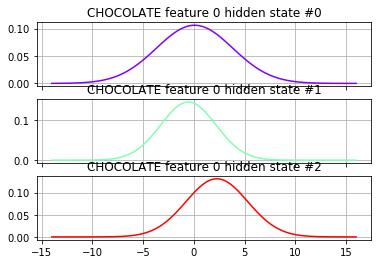

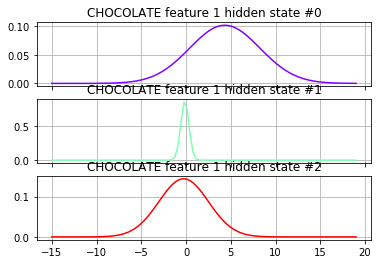

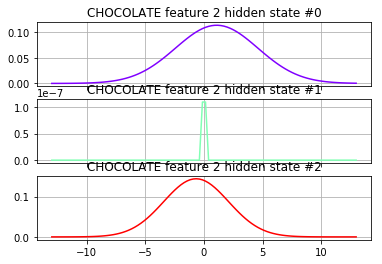

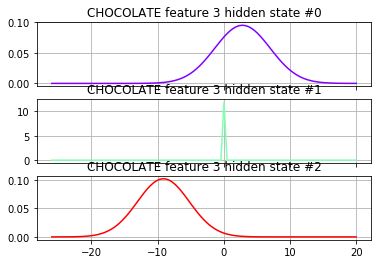

In [23]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [24]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [25]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
#print(word_sequences)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [26]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit
import warnings

In [26]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV
warnings.filterwarnings("ignore", category=RuntimeWarning) # warning caused by nan.mean when all elements are nan (model failed for that n). SelectorCV
training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))


Training complete for FISH with 3 states with time 0.03916343089124944 seconds
Training complete for BOOK with 11 states with time 13.140405284434637 seconds
Training complete for VEGETABLE with 5 states with time 5.1627404024335295 seconds
Training complete for FUTURE with 14 states with time 10.272997382870631 seconds
Training complete for JOHN with 15 states with time 111.38834721723315 seconds


In [27]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
warnings.filterwarnings("ignore", category=RuntimeWarning)
from my_model_selectors import SelectorBIC
training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 1.4416619626759655 seconds
Training complete for BOOK with 6 states with time 7.591246015862424 seconds
Training complete for VEGETABLE with 3 states with time 1.8812627221566345 seconds
Training complete for FUTURE with 4 states with time 10.303877798874453 seconds
Training complete for JOHN with 12 states with time 37.08423735481773 seconds


In [28]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 3 states with time 6.571472149524169 seconds
Training complete for BOOK with 9 states with time 8.693275288939077 seconds
Training complete for VEGETABLE with 3 states with time 6.512188182435011 seconds
Training complete for FUTURE with 10 states with time 10.296064042695093 seconds
Training complete for JOHN with 15 states with time 39.67323001659224 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:** CV, BIC and DIC models were used. Main differences among models are in their mathematical structures. CV used 2/3 of data for training, and 1/3 for testing. If data is scarce, less than 3 samples, CV was not used. DIC criterion is discriminative in a sence that it penalizes the model, that is likely to select competing (other than the trained word) words. Thus, it was the only criterion that was used here and considered the entire vocubolary of words available. DIC is considered the better model selector for classifications tasks. It tends to choose models with higher number of components/states. In this example here for 4 out of 5 words DIC chosed models with maximum of 15 states. BIC   

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [33]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 116.859s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [28]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer


from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        #print(word)
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [28]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [31]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [33]:
# TODO Choose a feature set and model selector


#Code below generates data for a table that's presented answering question 3. need to un-hash 'return' line in show_errors file
'''
features_all=[features_ground, features_norm, features_delta, features_polar, features_custom] # change as needed
selectors_all=[SelectorCV, SelectorBIC, SelectorDIC]
rez2=pd.DataFrame(index=['CV', 'BIC','DIC'], columns=['ground', 'norm', 'delta', 'polar', 'custom'])
for i in range(len(selectors_all)): # change as needed
    for j in range(len(features_all)): # change as needed
        models = train_all_words(features_all[j], selectors_all[i])
        test_set = asl.build_test(features_all[j])
        probabilities, guesses = recognize(models, test_set)
        WER=show_errors(guesses, test_set)
        print(WER, type(WER))
        rez2.iloc[i,j]=round(WER,3)
rez2.to_clipboard(index=True, header=True)

'''

"\nfeatures_all=[features_ground, features_norm, features_delta, features_polar, features_custom] # change as needed\nselectors_all=[SelectorCV, SelectorBIC, SelectorDIC]\nrez2=pd.DataFrame(index=['CV', 'BIC','DIC'], columns=['ground', 'norm', 'delta', 'polar', 'custom'])\nfor i in range(len(selectors_all)): # change as needed\n    for j in range(len(features_all)): # change as needed\n        models = train_all_words(features_all[j], selectors_all[i])\n        test_set = asl.build_test(features_all[j])\n        probabilities, guesses = recognize(models, test_set)\n        WER=show_errors(guesses, test_set)\n        print(WER, type(WER))\n        rez2.iloc[i,j]=round(WER,3)\nrez2.to_clipboard(index=True, header=True)\n\n"

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features_polar, SelectorBIC)
test_set = asl.build_test(features_polar)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [ ]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
models = train_all_words(features_ground, SelectorCV)
test_set = asl.build_test(features_ground)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

In [31]:
# TODO Choose a feature set and model selector
# TODO Recognize the test set and display the result with the show_errors method
from my_recognizer import recognize
from asl_utils import show_errors
from my_model_selectors import SelectorDIC
models = train_all_words(features_custom, SelectorDIC)
test_set = asl.build_test(features_custom)
probabilities, guesses = recognize(models, test_set)
show_errors(guesses, test_set)

85 178

**** WER = 0.47752808988764045
Total correct: 93 out of 178
Video  Recognized                                                    Correct
    2: *HIT WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *TOY                                          JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *FUTURE BUT CAN *CHICKEN CHICKEN          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *TELL *THROW *WHO *THROW                                 JOHN LIKE IX IX IX
   28: JOHN *WHO *ANN *WHO *NOT                                      JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *BILL VEGETABLE *GIRL *GIVE *MARY *MARY                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE 

In [32]:
import pickle
file=open('probabilities.txt','wb')
pickle.dump([probabilities, test_set, guesses], file)
file.close()

In [3]:
import pickle
file=open('probabilities.txt', 'rb')
probabilities, test_set, guesses=pickle.load(file)
file.close()

In [5]:
from asl_utils import show_errors
show_errors(guesses, test_set)

85 178

**** WER = 0.47752808988764045
Total correct: 93 out of 178
Video  Recognized                                                    Correct
    2: *HIT WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *TOY                                          JOHN CAN GO CAN
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *FUTURE BUT CAN *CHICKEN CHICKEN          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *TELL *THROW *WHO *THROW                                 JOHN LIKE IX IX IX
   28: JOHN *WHO *ANN *WHO *NOT                                      JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *BILL VEGETABLE *GIRL *GIVE *MARY *MARY                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE 

In [37]:
# here we check what were probabilities for the chosen word and the correct word. Sometimes it was the same word
p=0
for i in range(len(test_set.wordlist)):
    if test_set.wordlist[i] in df_probs.columns:
        print(guesses[i], round(max(df_probs.iloc[i]),1), '   ', test_set.wordlist[i], round(df_probs[test_set.wordlist[i]].iloc[i], 1))
        if df_probs[test_set.wordlist[i]].iloc[i]<0: 
            p+=1
            print('+++++++', guesses[i], round(max(df_probs.iloc[i]),1), '   ', test_set.wordlist[i], round(df_probs[test_set.wordlist[i]].iloc[i], 1))
    else: print('**************word {} not in train test'.format(test_set.wordlist[i]))

p

HIT 83.2     JOHN 69.8
WRITE 120.4     WRITE 120.4
HOMEWORK 167.1     HOMEWORK 167.1
JOHN 168.7     JOHN 168.7
PEOPLE 38.8     CAN 35.6
GO 48.5     GO 48.5
TOY 61.3     CAN 24.7
JOHN 42.1     JOHN 42.1
WHAT 41.9     CAN 35.9
GO1 64.3     GO -30.8
+++++++ GO1 64.3     GO -30.8
CAN 122.7     CAN 122.7
JOHN 168.9     JOHN 168.9
HOMEWORK 118.8     FISH 106.1
WONT 57.4     WONT 57.4
FUTURE 100.9     EAT 71.0
BUT 49.4     BUT 49.4
CAN 36.5     CAN 36.5
CHICKEN 42.7     EAT 36.9
CHICKEN 80.4     CHICKEN 80.4
ANN 68.3     JOHN 65.3
TELL 49.0     LIKE 46.4
THROW 89.7     IX 67.3
WHO 67.2     IX 49.2
THROW 71.4     IX 69.4
JOHN 60.9     JOHN 60.9
WHO 67.3     LIKE 41.1
ANN 72.2     IX 55.0
WHO 76.8     IX 61.8
NOT 74.2     IX 65.0
JOHN 80.9     JOHN 80.9
MARY 48.1     LIKE 47.8
MARY 67.6     IX 54.9
MARY 66.2     IX 51.9
MARY 46.1     IX 42.6
BILL 145.8     MARY 136.1
VEGETABLE 173.3     VEGETABLE 173.3
GIRL 85.7     KNOW 71.4
GIVE 46.5     IX 26.9
MARY 44.7     LIKE 39.4
MARY 190.0     CORN1 -2

10

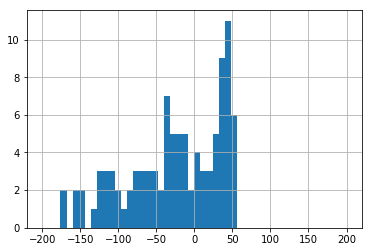

In [43]:
% matplotlib inline
df_probs.iloc[50].hist(range=[-200, 200], bins=50)

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:** Table below demonstrates WER values for all 15 possible combinations (including custom; delta for polar).

    ground	norm	delta	polar	custom
CV	0.539	0.601	0.618	0.556	0.506

BIC	0.551	0.612	0.618	0.545	0.539

DIC	0.573	0.596	0.629	0.545	0.478

WER ranged from 0.478 to 0.629 across all possibilities. Polar coordinate system (polar features) and custom features were lower compared to norm and delta features. However, all difference are relatively small. Variability across selectors for the given features set is relatively low: for norm features WER increased from 0.596 (DIC) to 0.612 (CV). 

In some cases, WER's are equal: CV/delta and BIC/delta both are equal to 0.618. Closer examination showed that both models failed at the same sentences but failures were different. For example phrase 2 was "John write homework" - CV read it as "John IX homework", while BIC read it as "John love homework". 

Relatively low variability in WER and lower bound for WER on average being >50% among models with various selectors and features indicates that major source of errors is outside the models grasps. Quick glance at errors shows occasional duplications of words, for example: "JOHN *JOHN BLAME".

Custom features demonstrated the best performance across the variety of selectors when compared to other features.

16 out of 40 sentences were recognized as starting with an incorrect word during test_set challenge. Interestingly, 5 out of 16 would have been correct if the word with the second largest probability was chosen.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [47]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 73.873s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [36]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-427.265216,60.855960,-60.043712,-19.945709,-151.993757,52.621877,-155.306022,-454.398513,-48.139049,-225.727420,...,-34.759131,25.826667,-52.544239,-84.891030,42.251060,-14.282839,-124.348865,-5.741563,-109.701709,30.160889
1,-1451.400952,-784.061017,-1704.063695,60.761521,-2247.583235,40.140561,-311.524122,78.908418,3.404890,-222.479106,...,91.711932,3.661148,-2.904167,-176.480224,43.212471,-659.048391,-217.867176,-27.738499,120.445372,-29.708915
2,-2029.335173,-830.003079,-2777.026820,41.288113,-2695.796030,47.989266,-526.934603,-247.646987,32.561309,-464.640510,...,49.679771,10.778312,26.154792,-357.469372,7.143990,-795.821064,-461.608913,-26.765867,-156.276505,-35.621417
3,42.056279,-533.465917,-51.440745,26.831783,108.963639,-6.987339,71.074573,-524.186649,-298.907664,-211.294383,...,-853.900993,53.815898,-864.636751,79.034342,-115.511567,-108.640502,81.234670,127.169647,-468.934907,-140.192545
4,-286.086492,-130.514594,-346.828146,22.402520,-516.488593,23.023951,-33.140141,13.379468,22.230790,27.263020,...,-8.240647,29.818702,-20.312437,26.575994,-127.163319,-149.509867,-30.435406,-92.455810,-29.057968,-38.348023
5,-126.373990,-224.713093,-170.534246,21.783557,-92.637159,-12.434151,13.833633,-129.429725,-107.039683,-55.178028,...,-314.434226,-6.812091,-408.783066,2.929530,-209.748730,-129.972215,-1.114950,-35.683583,-204.588596,-253.269822
6,-326.693406,-252.400652,-658.537596,28.329433,-639.015745,-30.042697,-88.109480,-73.710939,-48.452350,37.315406,...,-220.642824,-3.848128,-325.588047,11.294997,-583.851755,-295.623311,-227.229748,-429.906886,-217.254606,-360.179602
7,-179.066923,12.622674,-182.663962,26.685453,-221.825721,15.783046,-27.228613,-36.098386,18.792399,-3.759671,...,-45.871046,5.802687,-27.069637,8.269859,-43.061872,-9.404611,12.399773,6.816280,-40.584869,-25.700258
8,-487.623719,-339.021895,-642.400286,16.675675,-813.232670,24.013811,-71.667685,-30.943183,-6.925260,-15.627079,...,-18.597129,7.559427,21.413019,41.920800,-77.045370,-292.350108,-63.319567,-154.846239,-27.623504,-48.036093
9,-497.966988,-256.754064,-582.649254,30.832461,-779.224736,45.502861,-98.703442,-32.967654,26.270243,19.914357,...,-25.481567,36.986387,34.533880,51.389948,-77.058308,-228.021561,2.144306,-65.999533,-68.132684,-13.825190


In [6]:
def rem_duplicate_names(probabilities):  # remove word 'BUY1" and replaces with "BUY" assigning max probability among the two
    probabilities2=[]
    import re
    import copy
    names=list(probabilities[0].keys())
    for i in range(len(probabilities)):
        D=copy.copy(probabilities[i])
        for name, pr in probabilities[i].items():
    #name=names.pop(0)
            name2=re.sub(r'\d+','',name)
    #ind=names.index(name2)
    #for name2 in names:
            if len(name2)<len(name) and name2 in probabilities[i]:
            #ind=names.index(name2)
                #print(name, name2, probabilities[i][name], probabilities[i][name2])
                D[name2]=max(D[name2],D[name])
                del D[name]
        #rep_col = [col for col in df_probs.columns if name2==col] 
        #print(name2, rep_col, name)
        probabilities2.append(D)
    return probabilities2
            

In [7]:
probabilities2=rem_duplicate_names(probabilities)
guesses2=[]
for D in probabilities2:    
    highest_prob=sorted(D.values(), reverse=True)[0:2]
    for k,v in D.items():
        if v==highest_prob[0]:
            guesses2.append(k)
            break

In [8]:
def norm_prob_sent_1word(probabilities2):
    L=[]
    for i in range(len(probabilities2)):
        D={}
        for k,v in probabilities2[i].items():
            if v>0:
                D[k]=v
        L.append(D)
    return L

In [9]:
probabilities4=norm_prob_sent_1word(probabilities2)

In [10]:
show_errors(guesses2, test_set)

80 178

**** WER = 0.449438202247191
Total correct: 98 out of 178
Video  Recognized                                                    Correct
    2: *HIT WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN *PEOPLE GO *TOY                                          JOHN CAN GO CAN
   12: JOHN *WHAT GO CAN                                             JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *FUTURE BUT CAN *CHICKEN CHICKEN          JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: *ANN *TELL *THROW *WHO *THROW                                 JOHN LIKE IX IX IX
   28: JOHN *WHO *ANN *WHO *NOT                                      JOHN LIKE IX IX IX
   30: JOHN *MARY *MARY *MARY *MARY                                  JOHN LIKE IX IX IX
   36: *BILL VEGETABLE *GIRL *GIVE *MARY *MARY                       MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *CORN MARY *MARY                                   JOHN IX THINK MARY LOVE
   43: JOHN *PAST BUY HOUSE   

In [53]:
test_set.sentences_index

{2: [0, 1, 2],
 7: [3, 4, 5, 6],
 12: [7, 8, 9, 10],
 21: [11, 12, 13, 14, 15, 16, 17, 18],
 25: [19, 20, 21, 22, 23],
 28: [24, 25, 26, 27, 28],
 30: [29, 30, 31, 32, 33],
 36: [34, 35, 36, 37, 38, 39],
 40: [40, 41, 42, 43, 44],
 43: [45, 46, 47, 48],
 50: [49, 50, 51, 52, 53],
 54: [54, 55, 56, 57, 58],
 57: [59, 60, 61, 62],
 67: [63, 64, 65, 66, 67],
 71: [68, 69, 70, 71],
 74: [72, 73, 74, 75],
 77: [76, 77, 78],
 84: [79, 80, 81, 82],
 89: [83, 84, 85, 86, 87, 88, 89],
 90: [90, 91, 92, 93, 94, 95],
 92: [96, 97, 98, 99, 100, 101],
 100: [102, 103, 104, 105],
 105: [106, 107],
 107: [108, 109, 110, 111, 112],
 108: [113, 114],
 113: [115, 116, 117, 118, 119],
 119: [120, 121, 122, 123, 124],
 122: [125, 126, 127],
 139: [128, 129, 130, 131, 132],
 142: [133, 134, 135, 136, 137],
 158: [138, 139, 140],
 167: [141, 142, 143, 144, 145],
 171: [146, 147, 148],
 174: [149, 150, 151, 152, 153],
 181: [154, 155],
 184: [156, 157, 158, 159, 160],
 189: [161, 162, 163, 164],
 193: [165, 

In [59]:
def read_testset_set(probabilities4, filename, test_set):
    import time
    t1=time.time()
    
    ## get arpa model for LM
    import arpa
    models=arpa.loadf(filename,'r')
    lm=models[0]
    ## as defind in previous chapter
    guesses=[]
    
    
    for k,v in test_set.sentences_index.items():
        tl=read_sent_set(probabilities4, lm, v)
        words=tl.split()
        for word in words:
            guesses.append(word)
    t2=time.time()
    print(t2-t1)
    show_errors(guesses, test_set)
    return guesses, t2-t1

In [60]:
def read_testset_orig(probabilities4, filename, test_set):
    import time
    t1=time.time()
    
    ## get arpa model for LM
    import arpa
    models=arpa.loadf(filename,'r')
    lm=models[0]
    ## as defind in previous chapter
    guesses=[]
    
    
    for k,v in test_set.sentences_index.items():
        tl=read_sent_orig(probabilities4, lm, v)
        words=tl.split()
        for word in words:
            guesses.append(word)
    t2=time.time()
    print(t2-t1)
    show_errors(guesses, test_set)
    return guesses, t2-t1

In [90]:
def read_sent_set(probabilities4, lm, v):
    import copy
    frontier=set()
    
    ## initiate frontier: first potential word of the sentence
    for w1 in list(probabilities4[v[0]].keys()):
        prob_start_sent=lm.log_p(" ".join(['<s>', w1]))
        hmm_prob=probabilities4[v[0]][w1]
        frontier.add((1,w1,prob_start_sent, hmm_prob))
    
    ## build possible sentences
    for i in range(1,len(v)): 
        new_frontier=set()
        
        ## reduces frontier for sentences longer than 3 words
        node=frontier.pop()
        if node[0]%3==0:
            frontier.add(node)
            frontier=reduce_frontier_set(frontier,lm)
        else: frontier.add(node)
        
        while len(frontier):
            node=frontier.pop()  # data on start of sentence
         
            ## add next word
            for w2, hmm_w2 in probabilities4[v[i]].items():
                new_frontier.add((i+1, ' '.join([node[1], w2]), node[2], hmm_w2+node[3]))
        frontier=copy.copy(new_frontier)
    
    ## select the winning sentence
    senten=select_sentence_set(frontier, lm)
  
    return senten

In [96]:
% timeit read_sent_orig(probabilities4, lm, [115,116,117,118,119])

1 loop, best of 3: 1min 31s per loop


In [95]:
read_sent_set(probabilities4, lm, [115,116,117,118,119])

'IX CAR BLUE SUE BUY'

In [97]:
% timeit read_sent_set(probabilities4, lm, [115,116,117,118,119])

1 loop, best of 3: 1min 31s per loop


In [62]:
def read_sent_orig(probabilities4, lm, v):
    import heapq
    frontier=[]  
    ## initiate frontier: first potential word of the sentence
    for w1 in list(probabilities4[v[0]].keys()):
        prob_start_sent=lm.log_p(" ".join(['<s>', w1]))
        hmm_prob=probabilities4[v[0]][w1]
        heapq.heappush(frontier, (1,w1,prob_start_sent, hmm_prob))

    for i in range(1,len(v)): 
        ## reduces frontier for sentences longer than 3 words
        if frontier[0][0]%3==0:       
            frontier=reduce_frontier(frontier,lm)
        
        while frontier[0][0]==i:
            
            ## completion of sentence test:
            words=frontier[0][1].split()
            if len(words)==len(v):
                break
                continue
              
            # add next word
            node=heapq.heappop(frontier)
            for w2, hmm_w2 in probabilities4[v[i]].items():
                heapq.heappush(frontier, (i+1, ' '.join([node[1], w2]), node[2], hmm_w2+node[3]))
    
    ## select the winning sentence
    senten=select_sentence(frontier, lm)
  
    return senten

In [63]:
def select_sentence_set(frontier,lm):
    fr=set()
    
    while len(frontier): #for node in frontier:
        node=frontier.pop()
        prob_lm=lm.log_s(node[1])  #
        #prob_lm=lm.log_s(node[1], sos=False)
        fr.add((node[3]/node[0]+prob_lm*4.5-node[2]*2.5, node[1]))
    fr2=list(fr)
    tl=sorted(fr2,reverse=True)
 
    return tl[0][1]    

In [64]:
def select_sentence_orig(frontier,lm):
    fr=[]
    frontier=set(frontier)
    while len(frontier): #for node in frontier:
        node=frontier.pop()
        prob_lm=lm.log_s(node[1])  #
        #prob_lm=lm.log_s(node[1], sos=False)
        fr.append((node[3]/node[0]+prob_lm*4.5-node[2]*2.5, node[1]))
    tl=sorted(fr,reverse=True)
 
    return tl[0][1]    

In [68]:
def reduce_frontier_set(frontier,lm):
    fr=set()
    while len(frontier):
        node=frontier.pop()
        prob_lm=lm.log_p(node[1])
        fr.add((node[3]/3+prob_lm*4.5-node[2]*2.5, node))
    fr2=list(fr)
    tl=sorted(fr2,reverse=True)
    tl2=tl[:100]   # chossing 100 trigrams with the highest probability
    fr2=set()
    for node in tl2:
        fr2.add(node[1])
   
    return fr2    

In [66]:
def reduce_frontier_orig(frontier,lm):
    fr=[]
    frontier=set(frontier)
    while len(frontier):
        node=frontier.pop()
        prob_lm=lm.log_p(node[1])
        fr.append((node[3]/3+prob_lm*4.5-node[2]*2.5, node))
    tl=sorted(fr,reverse=True)
    tl2=tl[:100]   # chossing 100 trigrams with the highest probability
    fr2=[]
    for node in tl2:
        fr2.append(node[1])
   
    return fr2    

In [98]:
guesses, time=read_testset_set(probabilities4, 'ukn.3.lm', test_set)

15466.908948659897
38 178

**** WER = 0.21348314606741572
Total correct: 140 out of 178
Video  Recognized                                                    Correct
    2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
   21: JOHN *HOMEWORK WONT *JOHN BUT CAN EAT CHICKEN                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
   25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   28: JOHN *MARY *LOVE *WHO IX                                      JOHN LIKE IX IX IX
   30: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
   36: MARY VEGETABLE KNOW IX LIKE *MARY                             MARY VEGETABLE KNOW IX LIKE CORN1
   40: JOHN *GIVE *GIRL *VISIT *MARY                                 JOHN IX THINK MARY LOVE
   43: J

In [18]:
import arpa
models=arpa.loadf('ukn.3.lm','r')
lm=models[0]

In [100]:
time

15466.908948659897

38 178
Reducing frontier to 100 nodes every 3 words added to a sentence. It took over 4 hours to calculate.
Multiplication factors 4.5 and -2.5

**** WER = 0.21348314606741572
Total correct: 140 out of 178
Video  Recognized                                                    Correct
=================================================================
     2: JOHN WRITE HOMEWORK                                           JOHN WRITE HOMEWORK
    7: JOHN CAN GO CAN                                               JOHN CAN GO CAN
    12: JOHN CAN GO CAN                                               JOHN CAN GO CAN
    21: JOHN *HOMEWORK WONT *JOHN BUT CAN EAT CHICKEN                 JOHN FISH WONT EAT BUT CAN EAT CHICKEN
    25: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
    28: JOHN *MARY *LOVE *WHO IX                                      JOHN LIKE IX IX IX
    30: JOHN LIKE IX IX IX                                            JOHN LIKE IX IX IX
    36: MARY VEGETABLE KNOW IX LIKE *MARY                             MARY VEGETABLE KNOW IX LIKE CORN1
    40: JOHN *GIVE *GIRL *VISIT *MARY                                 JOHN IX THINK MARY LOVE
    43: JOHN *FUTURE BUY HOUSE                                        JOHN MUST BUY HOUSE
    50: *FRANK *POSS *NEW CAR *ARRIVE                                 FUTURE JOHN BUY CAR SHOULD
    54: JOHN SHOULD NOT BUY HOUSE                                     JOHN SHOULD NOT BUY HOUSE
    57: JOHN DECIDE VISIT MARY                                        JOHN DECIDE VISIT MARY
    67: JOHN FUTURE NOT BUY HOUSE                                     JOHN FUTURE NOT BUY HOUSE
    71: JOHN WILL VISIT MARY                                          JOHN WILL VISIT MARY
    74: JOHN NOT VISIT MARY                                           JOHN NOT VISIT MARY
    77: ANN BLAME MARY                                                ANN BLAME MARY
    84: *SOMETHING-ONE *STUDENT *VISIT BOOK                           IX-1P FIND SOMETHING-ONE BOOK
    89: *GIVE *GIVE GIVE *IX IX NEW COAT                              JOHN IX GIVE MAN IX NEW COAT
    90: JOHN GIVE IX SOMETHING-ONE WOMAN BOOK                         JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
    92: JOHN GIVE IX SOMETHING-ONE WOMAN BOOK                         JOHN GIVE IX SOMETHING-ONE WOMAN BOOK
    100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    105: JOHN *FUTURE                                                  JOHN LEG
    107: JOHN POSS FRIEND *VISIT *MARY                                 JOHN POSS FRIEND HAVE CANDY
    108: *THINK *BOOK                                                  WOMAN ARRIVE
    113: IX CAR BLUE SUE BUY                                           IX CAR BLUE SUE BUY
    119: SUE BUY IX CAR *FUTURE                                        SUE BUY IX CAR BLUE
    122: JOHN READ BOOK                                                JOHN READ BOOK
    139: JOHN BUY WHAT YESTERDAY BOOK                                  JOHN BUY WHAT YESTERDAY BOOK
    142: JOHN BUY YESTERDAY WHAT BOOK                                  JOHN BUY YESTERDAY WHAT BOOK
    158: LOVE JOHN WHO                                                 LOVE JOHN WHO
    167: JOHN IX *JOHN LOVE MARY                                       JOHN IX SAY LOVE MARY
    171: JOHN MARY BLAME                                               JOHN MARY BLAME
    174: PEOPLE GROUP *GIVE *GIRL *BOX                                 PEOPLE GROUP GIVE1 JANA TOY
    181: *SUE ARRIVE                                                   JOHN ARRIVE
    184: ALL BOY GIVE TEACHER APPLE                                    ALL BOY GIVE TEACHER APPLE
    189: *MARY *SELF *PREFER BOX                                       JOHN GIVE GIRL BOX
    193: JOHN GIVE GIRL BOX                                            JOHN GIVE GIRL BOX
    199: LIKE CHOCOLATE WHO                                            LIKE CHOCOLATE WHO
    201: JOHN *GIVE *IX *MAN BUY HOUSE                                 JOHN TELL MARY IX-1P BUY HOUSE


In [45]:
s=set()
s.add('fg')
s.add('tr')
len(s)

2

In [105]:
lm.log_p(' '.join(['FUTURE','</s>']))show_errors(guesses2, test_set)

-0.5022029

In [124]:
time

19545.268880605698

In [78]:
import arpa
models=arpa.loadf('ukn.3.lm','r')
lm=models[0]

In [103]:
#df_probs2 = pd.DataFrame(data=probabilities2)
t1=time.time()
def read_sent_old(probabilities4, lm, v):
    if len(v)==3:
        trigrams={}
        trigrams_l=[]
        for i in [0]: 
            for w1 in list(probabilities4[v[0]].keys()):
                for w2 in list(probabilities4[v[1]].keys()):
                    for w3 in list(probabilities4[v[2]].keys()):
                                     
                        trigram=' '.join([w1,w2,w3])
                        prob=(probabilities4[v[0]][w1]+probabilities4[v[1]][w2]+probabilities4[v[2]][w3])/3
                        prob_lm=lm.log_s(trigram)
                        prob_lm_st=lm.log_p(" ".join(['<s>', w1]))
                        trigrams[trigram]=(prob, prob_lm, prob_lm_st)
                        end_prob=lm.log_p(" ".join([w3, '</s>']))
                        trigrams_l.append((prob+prob_lm*4.5-prob_lm_st*2.5-end_prob*2, trigram, prob, prob_lm, prob_lm_st, end_prob))
        tl=sorted(trigrams_l,reverse=True)
        return tl[:5]

In [104]:
read_sent_old(probabilities4,lm, [122,123,124])

[(39.762221843691336,
  'IX CAR FUTURE',
  55.721286043691343,
  -4.484380000000002,
  -1.286496,
  -0.5022029),
 (36.608627938945382,
  'IX VISIT MARY',
  50.420852028945376,
  -3.936613219999998,
  -1.286496,
  -0.3431477),
 (36.603139954431796,
  'BLUE CAR FUTURE',
  55.685645354431784,
  -6.389098599999997,
  -3.4656130000000003,
  -0.5022029),
 (33.872999649685816,
  'BLUE VISIT MARY',
  50.385211339685817,
  -5.747231020000001,
  -3.4656130000000003,
  -0.3431477),
 (33.242057243011779,
  'IX CAR BLUE',
  42.243506528011785,
  -2.984513530000001,
  -1.286496,
  -0.6063108)]

In [799]:
def prob_lm_dict(probabilities3, A, B, C):
    import copy
    l1=copy.copy(list(probabilities3[0].keys()))
    l2=copy.copy(list(probabilities3[0].keys()))
    l3=copy.copy(list(probabilities3[0].keys()))
    l1.append('<s>')
    l3.append('</s>')
    D={}
    #Dmin, Dmax=float('inf'), float('-inf')
    Dmin, Dmax=-3.6554496*1.01, -0.03308267 # from previous run, 1.01 factor is to avoid data point with P=0 (problem when 1/P)
    #print(len(l1), len(l2),len(l3))
    for w1 in l1:
        for w2 in l2:
            for w3 in l3:
                trigram=' '.join([w1, w2, w3])
                logL_lm=prob_trigram(trigram, C, B, A)
                if not np.isnan(logL_lm): 
                    #D[trigram]=logL_lm
                    #if logL_lm>Dmax: Dmax=logL_lm
                    #if logL_lm<Dmin: Dmin=logL_lm
                    D[trigram]=(logL_lm-Dmin)/(Dmax-Dmin)
    return D #, Dmin, Dmax

In [787]:
def ngrams():
    filename=open('devel-lm-M3.sri.lm','r')
    unigram={}
    bigram={}
    trigram={}
    #un_min, un_max, bi_min, bi_max, tri_min, tri_max=float('+inf'), float('-inf'),float('+inf'), float('-inf'),float('+inf'), float('-inf'),
    un_min, bi_min, tri_min=-2.483841, -2.712613, -1.785581   #determined and earlier run
    un_max, bi_max, tri_max=-0.9039146, -0.0594274, -0.03308267
    #scaling factors:
    a=1 #max([un_max, bi_max, tri_max])
    b=0 #min([un_min, bi_min, tri_min])*0.99  # otherwise there is a value with log prob==0
    start_unigram=False
    start_bigram=False
    start_trigram=False
    for line in filename:
        line=line.strip()
    #print(line)
        if line.startswith('\\1-grams'):
            start_unigram=True
            continue
        if line.startswith('\\2-grams'):
            start_unigram=False
            start_bigram=True
            continue
        if line.startswith('\\3-grams'):
            start_trigram=True
            start_bigram=False
            continue
        if line.startswith('\\end'):
            start_trigram=False
            continue
        items=line.split(sep='\t')
        if items[0]:
            if start_unigram:
                if items[0]: 
                    if len(items)==3:
                        unigram[items[1]]=((float(items[0])-b)/(a-b), (float(items[2])-b)/(a-b))
                    else: unigram[items[1]]=((float(items[0])-b)/(a-b),)
                    #if float(items[0])<un_min and float(items[0])>-99: un_min=float(items[0])
                    #if float(items[0])>un_max: un_max=float(items[0])
            if start_bigram:
                if items[0]: 
                    if len(items)==3:
                        bigram[items[1]]=((float(items[0])-b)/(a-b), (float(items[2])-b)/(a-b))
                    else: bigram[items[1]]=((float(items[0])-b)/(a-b),)   
                    #if float(items[0])<bi_min: bi_min=float(items[0])
                    #if float(items[0])>bi_max: bi_max=float(items[0])
            if start_trigram:
                if items[0]: 
                    trigram[items[1]]=((float(items[0])-b)/(a-b),)
                    #if float(items[0])<tri_min: tri_min=float(items[0])
                    #if float(items[0])>tri_max: tri_max=float(items[0])
    filename.close()
    #print(un_min, bi_min, tri_min)
    #print(un_max, bi_max, tri_max)
    return unigram, bigram, trigram

In [788]:
A, B, C=ngrams()

In [397]:
lm.log_s('MARY MARY BLAME')

-5.843264000000005

In [414]:
trigrams['ANN CHOCOLATE WHO']

(340.46426876049088, -6.2256399000000044, -2.57865)

In [388]:
trigrams['MARY MARY BLAME']

(264.93833551754744, 1.4346170896671342e-06, 0.04695826042059558)

In [410]:
tl=sorted(trigrams_l,reverse=True)

In [411]:
tl[:10]

[(286.73231009489302, 'JOHN CHOCOLATE WHO'),
 (275.66271721635314, 'JOHN ARRIVE WHO'),
 (275.08084272723147, 'JOHN LOVE WHO'),
 (269.51019247472516, 'JOHN NEW WHO'),
 (265.02845393163221, 'JOHN HOMEWORK WHO'),
 (263.35433291677788, 'JOHN GIVE WHO'),
 (259.95173830826684, 'SOMETHING-ONE CHOCOLATE WHO'),
 (259.27157919535563, 'JOHN NEW-YORK WHO'),
 (258.03152183260499, 'IX CHOCOLATE WHO'),
 (256.98289384684597, 'JOHN VIDEOTAPE WHO')]

In [356]:
len(trigrams)

19530

In [45]:
probabilities4[0]

{'ANN': 60.855959637065467,
 'BLAME': 52.621877353835814,
 'FIND': 68.243808706926586,
 'FINISH': 7.0795607517810684,
 'FRANK': 38.304533614393392,
 'FRED': 61.491237594663154,
 'FUTURE': 82.046645627379107,
 'GO': 78.286728280737222,
 'HIT': 83.168858320901819,
 'IX': 54.637935408657029,
 'IX-1P': 56.606486153418061,
 'JOHN': 69.763924575299882,
 'LEG': 30.14091778137022,
 'MAN': 15.483418241117647,
 'MARY': 17.314011632593473,
 'MOTHER': 78.610912330170706,
 'NOT': 46.323456189571687,
 'OLD': 9.358201140752012,
 'PAST': 68.943065439329857,
 'POSS': 73.461494445166409,
 'PREFER': 55.42115025362083,
 'SEE': 27.625804705479254,
 'SHOULD': 52.61375588283277,
 'SOMETHING-ONE': 49.358674101954442,
 'TELL': 48.432188698858695,
 'THROW': 2.0983994960861025,
 'TOMORROW': 34.695937214336595,
 'VISIT': 25.826667311688208,
 'WHO': 42.251059535525272,
 'YESTERDAY': 30.160888738374734}

In [240]:

#for k,v in test_set.sentences_index.items():
#    if len(v)==3:
 #   sentence_trigrams=[]    
    for i in list(range(len(v))):  # to scan all words in the sentences plus <s> and </s>. 
        trigrams=[]
        last_trigrams=[]
        for w1 in list(df_probs.columns):
            if i==0: 
                trigram=' '.join(['<s>','<s>',w1])
                prob=probabilities[v[i]][w1]
                prob_lm=prob_trigram(trigram, C, B, A)
                trigrams.append((trigram, prob, prob_lm))
            else:
                for w2 in list(df_probs.columns):
                    if i==1: 
                        trigram=' '.join(['<s>', w1, w2])
                        prob=probabilities[v[i-1]][w1]+probabilities[v[i]][w2] 
                        prob_lm=prob_trigram(trigram, C, B, A)
                        trigrams.append((trigram, prob, prob_lm))
                    else:                 
                        for w3 in list(df_probs.columns):
 
                            trigram=' '.join([w1,w2,w3])
                            last_trigram=' '.join([w2,w3,'</s>'])
                            prob=probabilities[v[i-2]][w1]+probabilities[v[i-1]][w2]+probabilities[v[i]][w3]
                            prob_lm=prob_trigram(trigram, C, B, A)
                            last_trigrams.append((last_trigram,np.nan, prob_trigram(last_trigram, C, B, A)))
                            trigrams.append((trigram, prob, prob_lm))
        sentence_trigrams.append(trigrams)

    sentence_trigrams.append(last_trigrams)
t3=time.time()-t1

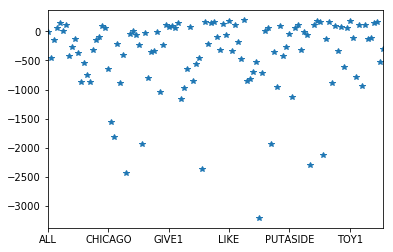

In [345]:
df_probs.iloc[39].plot(style='*')

In [336]:
def normalize_probab(probabilities):
    prob2=[]
    df_probs = pd.DataFrame(data=probabilities)
         #combine BUY and BUY1 words into one column by summing their logL's   
    #for name in 
    for i in range(len(probabilities)):

        
        D={}
        treshold_min=0 #df_probs.iloc[i].sort_values()[9]  # disregards the lowest 9 numbers as outlayers
        treshold_max=df_probs.iloc[i].max()
        for k,v in probabilities[i].items():
            if v>treshold_min: D[k]=(v-treshold_min)/(treshold_max-treshold_min)
            else: D[k]=np.nan
        prob2.append(D)
    return prob2

In [491]:
probabilities2=rem_duplicate_names(probabilities)

In [492]:
probabilities2[67]['FUTURE']-probabilities[67]['FUTURE']-probabilities[67]['FUTURE1']

0.0

In [338]:
probabilities31=normalize_probab(probabilities2)
df_probs3 = pd.DataFrame(data=probabilities31)
probabilities31

[{'ALL': nan,
  'ANN': 0.73171570303702582,
  'APPLE': nan,
  'ARRIVE': nan,
  'BILL': nan,
  'BLAME': 0.63271131065425479,
  'BLUE': nan,
  'BOOK': nan,
  'BORROW': nan,
  'BOX': nan,
  'BOY': nan,
  'BREAK-DOWN': nan,
  'BROCCOLI': nan,
  'BROTHER': nan,
  'BUT': nan,
  'BUY': nan,
  'CAN': nan,
  'CANDY': nan,
  'CAR': nan,
  'CHICAGO': nan,
  'CHICKEN': nan,
  'CHINA': nan,
  'CHOCOLATE': nan,
  'COAT': nan,
  'CORN': nan,
  'DECIDE': nan,
  'EAT': nan,
  'FIND': 0.82054521469577146,
  'FINISH': 0.085122735777675679,
  'FISH': nan,
  'FRANK': 0.46056341745846446,
  'FRED': 0.73935411446196697,
  'FRIEND': nan,
  'FUTURE': 0.98650681617880664,
  'GET': nan,
  'GIRL': nan,
  'GIVE': nan,
  'GO': 0.94129858051763549,
  'GROUP': nan,
  'HAVE': nan,
  'HERE': nan,
  'HIT': 1.0,
  'HOMEWORK': nan,
  'HOUSE': nan,
  'IX': 0.65695185086994923,
  'IX-1P': 0.6806211759575379,
  'JANA': nan,
  'JOHN': 0.83882267935096766,
  'KNOW': nan,
  'LAST-WEEK': nan,
  'LEAVE': nan,
  'LEG': 0.362406294

In [633]:
# will try UCS using heaps
def read_sentence(test_set, probabilities3, A, B, C, indices):
    # indices are index's of words from the test_set.words that form a sentence
    import heapq
    import copy
    starters=[]
    t1=time.time()
    for i in list(range(len(indices))):  # to scan all words in the sentences plus <s> and </s>. 
     
        if not len(starters): # for first word in a sentence
            #last_trigrams=[]
            for w1 in list(probabilities3[i].keys()):
                #print(w1)
                bigram=' '.join(['<s>',w1])
                logprob=probabilities3[indices[i]][w1] 
                logprob_lm=prob_bigram(bigram, B, A) 
                #print(logprob, logprob_lm, w1)
                if not np.isnan(logprob) or not np.isnan(logprob_lm): 
                    pp=1/((np.nansum([logprob,logprob_lm*0.8]))**(0.5)) # perplexity of word in the begining of the sentence
               
                    heapq.heappush(starters, (pp, logprob, logprob_lm, bigram)) #trigrams.append((trigram, prob, prob_lm))
        else:
            starters2=copy.copy(starters)
            if True:
                next_words=[]
                while len(starters): #while True:
                    start_trigram=heapq.heappop(starters)
                    part_gram=start_trigram[3].split()
                    #print(part_gram)
                    for word, prob in probabilities3[indices[i]].items(): 
                                          
                        trigram=' '.join([' '.join([part_gram[-2], part_gram[-1]]), word])
                        #print(trigram)
                        logprob=probabilities3[indices[i]][word]
                        logprob_lm=prob_trigram (trigram, C, B, A)
                        print(logprob, logprob_lm, start_trigram[0], trigram)
                        if not np.isnan(logprob) or not np.isnan(logprob_lm):
                            pp=1/((np.nansum([logprob,logprob_lm*0.8])+1/start_trigram[0])**(0.5))
                            heapq.heappush(next_words, (pp, logprob, logprob_lm, ' '.join([start_trigram[3],word])))

    print(time.time()-t1)
    return(next_words, starters2)

In [894]:
# will try UCS using heaps
def read_sentence_heap(logL_lm, probabilities3, starters_dict, indices):
    # indices are index's of words from the test_set.words that form a sentence
    import heapq
    import copy
    starters=[]
    answer=[]
    explored=set()
    prob_heap=hmmprob_to_heaps(probabilities3) # word recognition pseudo-perplexity (1/p) from HMM
    t1=time.time()
    Cost=float('inf')
    while True: #for i in list(range(len(indices))):  # i is a line # in probabilities as well as an index of the word in test_set.wordlist
     
        if not len(starters): # for first word in a sentence
            #last_trigrams=[]
            for w1 in list(probabilities3[i].keys()):
                #print(w1)
                bigram=' '.join(['<s>',w1])
                logprob=probabilities3[indices[i]][w1] 
                logprob_lm=starters_dict[bigram]/200
                print(indices[i])
                if not np.isnan(logprob) and not np.isnan(logprob_lm): 
                    pp=1/((logprob*logprob_lm)**(0.5)) # pseudo-perplexity of word in the begining of the sentence
               
                    heapq.heappush(starters, (pp, bigram)) #trigrams.append((trigram, prob, prob_lm))
            nodes=copy.copy(starters)
            return nodes[0]
            print(starters)
        else:
            probab=copy.copy(prob_heap)
            #print(nodes)
            #if len(probab[len(words)-1])<1:
            #    continue
            new_node_a=heapq.heappop(nodes)
            if goal_test(new_node_a, indices): 
                #break
                return nodes
                
            text=new_node_a[-1]
            words=text.split()
            if len(words)==len(indices)+2: continue
            bigram=' '.join([words[-2], words[-1]])
            #if len(words)==len(indices)+2: 
            #    heapq.heappush(answer, new_node_a)
            print(words)
            while len(probab[len(words)-1])-100:
                if len(words)<len(indices)+1: 
                    word=heapq.heappop(probab[len(words)-1]) # -1 to adjust for an added <s> word to the begining of the sentence
                    logprob=1/word[0]
                    #print(word[0])
                    trigram=' '.join([bigram, word[1]])
                else:
                    trigram=' '.join([bigram, '</s>'])
                
                if trigram in logL_lm:
                    logprob_lm=logL_lm[trigram]
                else: logprob_lm=np.nan
                pp=(1/(1/new_node_a[0]*logprob*logprob_lm))**(1/3)
                
                if not np.isnan(pp): 
                    heapq.heappush(nodes, (pp, ' '.join([text, word[1]])))
                    print(pp, ' '.join([text, word[1]]), logprob, logprob_lm, new_node_a)


def goal_test(node, indices):
    return len(indices)==len(node[1])-2

In [876]:
test_set.sentences_index

{2: [0, 1, 2],
 7: [3, 4, 5, 6],
 12: [7, 8, 9, 10],
 21: [11, 12, 13, 14, 15, 16, 17, 18],
 25: [19, 20, 21, 22, 23],
 28: [24, 25, 26, 27, 28],
 30: [29, 30, 31, 32, 33],
 36: [34, 35, 36, 37, 38, 39],
 40: [40, 41, 42, 43, 44],
 43: [45, 46, 47, 48],
 50: [49, 50, 51, 52, 53],
 54: [54, 55, 56, 57, 58],
 57: [59, 60, 61, 62],
 67: [63, 64, 65, 66, 67],
 71: [68, 69, 70, 71],
 74: [72, 73, 74, 75],
 77: [76, 77, 78],
 84: [79, 80, 81, 82],
 89: [83, 84, 85, 86, 87, 88, 89],
 90: [90, 91, 92, 93, 94, 95],
 92: [96, 97, 98, 99, 100, 101],
 100: [102, 103, 104, 105],
 105: [106, 107],
 107: [108, 109, 110, 111, 112],
 108: [113, 114],
 113: [115, 116, 117, 118, 119],
 119: [120, 121, 122, 123, 124],
 122: [125, 126, 127],
 139: [128, 129, 130, 131, 132],
 142: [133, 134, 135, 136, 137],
 158: [138, 139, 140],
 167: [141, 142, 143, 144, 145],
 171: [146, 147, 148],
 174: [149, 150, 151, 152, 153],
 181: [154, 155],
 184: [156, 157, 158, 159, 160],
 189: [161, 162, 163, 164],
 193: [165, 

In [634]:
(next_words, starters)=read_sentence(test_set, probabilities3, A, B, C, [0,1])

0.931875024936 2.3027727485878664 0.783639462892 <s> JOHN JOHN
1.0 1.167901611677436 0.783639462892 <s> JOHN WRITE
0.959243426789 2.3027727485878664 0.783639462892 <s> JOHN HOMEWORK
0.360392906707 2.3027727485878664 0.783639462892 <s> JOHN IX-1P
0.448738930128 0.5455710219430357 0.783639462892 <s> JOHN SEE
0.904472666944 1.2375384339988607 0.783639462892 <s> JOHN YESTERDAY
0.585742475239 0.5419086842043155 0.783639462892 <s> JOHN IX
0.896879288265 1.5846886534111206 0.783639462892 <s> JOHN LOVE
0.898044320058 0.40665667397148597 0.783639462892 <s> JOHN MARY
0.943715647929 0.5530023930741778 0.783639462892 <s> JOHN CAN
0.74395919793 0.5783228174650004 0.783639462892 <s> JOHN GO
0.593894946242 0.6164900771911009 0.783639462892 <s> JOHN FUTURE
0.764049339141 2.3027727485878664 0.783639462892 <s> JOHN PARTY
0.692729238368 2.3027727485878664 0.783639462892 <s> JOHN HIT
0.948910520164 2.3027727485878664 0.783639462892 <s> JOHN BLAME
0.580089644375 2.3027727485878664 0.783639462892 <s> JOHN F

In [635]:
next_words

[(0.49374395675503113,
  0.98369191788112686,
  2.3027727485878664,
  '<s> JOHN COAT'),
 (0.49386267934515149,
  0.98171994308598487,
  2.3027727485878664,
  '<s> JOHN VIDEOTAPE'),
 (0.4940968811764615, 1.0, 2.433223789948757, '<s> IX WRITE'),
 (0.49435398912212392,
  0.97357441812082335,
  2.3027727485878664,
  '<s> JOHN BOOK'),
 (0.4940866318979914,
  0.97800397430880914,
  2.3027727485878664,
  '<s> JOHN STUDENT'),
 (0.49453646920158878,
  0.97055522485433421,
  2.3027727485878664,
  '<s> JOHN HOUSE'),
 (0.49585061957551291,
  0.94891052016438959,
  2.3027727485878664,
  '<s> JOHN BLAME'),
 (0.49499694483522533,
  0.96295134172016905,
  2.3027727485878664,
  '<s> JOHN BREAK-DOWN'),
 (0.49608477680594887,
  0.94507187967510464,
  2.3027727485878664,
  '<s> JOHN LIVE'),
 (0.49429645252244003,
  0.97452707363092217,
  2.3027727485878664,
  '<s> JOHN NEW'),
 (0.49577319741690612,
  0.9501809316635319,
  2.3027727485878664,
  '<s> JOHN MOVIE'),
 (0.49721579274052458,
  0.9266069448557433

In [733]:
logL_lm=prob_lm_dict(probabilities3, A, B, C)

In [735]:
len(logL_lm)

8424

In [707]:
B['JOHN WRITE'][0]+B['<s> JOHN'][1]

1.167901611677436

In [723]:
def hmmprob_to_heaps(probabilities3):
    import heapq
    prob=[]
    for line in probabilities3:
        l_prob=[]
        for k,v in line.items():
            heapq.heappush(l_prob, (1/v, k))
        prob.append(l_prob)
    return prob
            

In [769]:
prob_heap=hmmprob_to_heaps(probabilities3)
try1=prob_heap[0]

In [726]:
word=heapq.heappop(try1)

In [687]:
def prob_trigram(gram, trigram_model, bigram_model, unigram_model):
    backoff=np.nan
    pr=np.nan
    #gram - 3 word string, trigram_model-data on trigrams
    if gram in trigram_model:
        prob=trigram_model[gram][0]
        #print(prob)
    else:
        words=gram.split()
        bigram=" ".join([words[1], words[2]])
        boff_bi=" ".join([words[0], words[1]])
        #print(bigram, '     ',boff_bi)
        if bigram in bigram_model:
            pr=bigram_model[bigram][0]
        else:
            if words[1] in unigram_model:# and words[2] in unigram_model:
                pr1=unigram_model[words[1]][1]
            else: pr1=np.nan
            if words[2] in unigram_model:
                pr2=unigram_model[words[2]][0]
            else: pr2=np.nan
            pr=pr1+ pr2
            #print(pr1, pr2, pr)
        if boff_bi in bigram_model:
            if len(bigram_model[boff_bi])>1: backoff=bigram_model[boff_bi][1]
            else: backoff=np.nan
        prob=pr+ backoff
    return prob
     

In [603]:
prob_trigram('<s> VISIT WHO', C, B, A)

VISIT WHO       <s> VISIT


nan

In [400]:
def prob_bigram(gram, bigram_model, unigram_model):
    backoff=np.nan
    pr=np.nan
    #gram - 2 word string, trigram_model-data on trigrams
    words=gram.split()
    if gram in bigram_model:
        pr=bigram_model[gram][0]
    else:
        if words[0] in unigram_model:# and words[2] in unigram_model:
            pr1=unigram_model[words[0]][1]
        else: pr1=np.nan
        if words[1] in unigram_model:
            pr2=unigram_model[words[1]][0]
        else: pr2=np.nan
        pr=pr1+ pr2
    return pr
     

In [526]:
'<s> JOHN KLA'.split()[-2]

'JOHN'

In [847]:
def prob_starters(probabilities3, bigram_model, unigram_model):
    backoff=np.nan
    pr=np.nan
    D={}
    Dmin, Dmax=-3.2773754*1.01, -0.2530479
    for word in list(probabilities3[0].keys()):
        gram=" ".join(['<s>', word])
    #gram - 2 word string, trigram_model-data on trigrams
    #words=gram.split()
        if gram in bigram_model:
            pr=bigram_model[gram][0]
        else:
            if word in unigram_model:# and words[2] in unigram_model:
                pr1=unigram_model[word][0]
            else: pr1=np.nan
            #if words[1] in unigram_model:
            pr2=unigram_model['<s>'][1]
        #else: pr2=np.nan
            pr=pr1+ pr2
        D[gram]=(pr-Dmin)/(Dmax-Dmin)
    return D
     

In [852]:
starters_dict=prob_starters(probabilities3, B, A)

In [828]:
sentence_trigrams[0]

[]

In [219]:
for t in sentence_trigrams[3]:
    prob_trigram(t[0],C, B, A)

In [520]:
h

[(1, 5), (3, 5), (2, 5), (7, 5), (4, 5), (5, 5), (6, 5), (8, 5)]

In [519]:
heapq.heappop(h)

(0, 5)

In [80]:
sorted(sentence_trigrams[2],key=lambda item:item[1], reverse=True)

[('HIT WRITE HOMEWORK', 370.72327867925901),
 ('FUTURE1 WRITE HOMEWORK', 369.60106598573634),
 ('MOTHER WRITE HOMEWORK', 366.16533268852788),
 ('GO WRITE HOMEWORK', 365.8411486390944),
 ('POSS WRITE HOMEWORK', 361.01591480352363),
 ('JOHN WRITE HOMEWORK', 357.3183449336571),
 ('PAST WRITE HOMEWORK', 356.49748579768709),
 ('FIND WRITE HOMEWORK', 355.79822906528381),
 ('FRED WRITE HOMEWORK', 349.0456579530204),
 ('ANN WRITE HOMEWORK', 348.41037999542266),
 ('HIT COAT HOMEWORK', 345.08947976099012),
 ('IX-1P WRITE HOMEWORK', 344.16090651177524),
 ('FUTURE1 COAT HOMEWORK', 343.96726706746739),
 ('FUTURE WRITE HOMEWORK', 343.81755245018144),
 ('PREFER WRITE HOMEWORK', 342.97557061197801),
 ('IX WRITE HOMEWORK', 342.19235576701425),
 ('HIT VIDEOTAPE HOMEWORK', 341.98983842964884),
 ('FUTURE1 VIDEOTAPE HOMEWORK', 340.86762573612612),
 ('MOTHER COAT HOMEWORK', 340.53153377025899),
 ('GO COAT HOMEWORK', 340.2073497208255),
 ('BLAME WRITE HOMEWORK', 340.17629771219299),
 ('SHOULD WRITE HOMEWORK'

In [72]:
import arpa

In [48]:
models=arpa.loadf('devel-lm-M3.sri.lm','r')

In [49]:
lm=models[0]

In [50]:
lm.log_p("<s> JOHN")

-0.2530479

In [926]:
lm.log_s("JOHN CAN GO GO")

-5.2045439999999985

In [920]:
lm.log_s("HIT WRITE HOMEWORK")

-6.739432600000001

In [916]:
probabilities[0]['JOHN']+probabilities[1]['WRITE']+probabilities[2]['HOMEWORK']

357.3183449336571

In [917]:
probabilities[0]['JOHN']+probabilities[1]['CAN']+probabilities[2]['GO']

101.68381278551566

In [919]:
probabilities[0]['HIT']+probabilities[1]['WRITE']+probabilities[2]['HOMEWORK']

370.72327867925901

In [925]:
probabilities[0]

{'ALL': -427.26521631354177,
 'ANN': 60.855959637065467,
 'APPLE': -60.043712335892977,
 'ARRIVE': -19.945709148694373,
 'BILL': -151.99375659640026,
 'BLAME': 52.621877353835814,
 'BLUE': -155.3060220009807,
 'BOOK': -454.39851303966583,
 'BORROW': -48.139048560020917,
 'BOX': -225.72741994937934,
 'BOY': -120.44275534040359,
 'BREAK-DOWN': -354.50916483743538,
 'BROCCOLI': -60.109515270297273,
 'BROTHER': -20.450809929095069,
 'BUT': -213.31235284281092,
 'BUY': -45.294425313495715,
 'BUY1': -247.66921661608359,
 'CAN': -147.35463348690396,
 'CANDY': -369.44730483906721,
 'CAR': -49.573278637094297,
 'CHICAGO': -29.417468504223187,
 'CHICKEN': -209.89502936456253,
 'CHINA': -488.36966952828925,
 'CHOCOLATE': -125.99572568556157,
 'COAT': -268.2922592361532,
 'CORN': -1262.3265272736917,
 'CORN1': -37.45116414975022,
 'DECIDE': -408.13088239716836,
 'EAT': -27.279017498128717,
 'FIND': 68.243808706926586,
 'FINISH': 7.0795607517810684,
 'FISH': -291.80874251678165,
 'FRANK': 38.304533

In [80]:
def normalize_probab_sentence(probabilities, indices):
    prob2=[]
    df_probs = pd.DataFrame(data=probabilities)
         #combine BUY and BUY1 words into one column by summing their logL's   
    va=[]
    va2=[]
    for i in range(len(indices)):
        treshold_min=df_probs.iloc[indices[i]].sort_values()[9]  # disregards the lowest 9 numbers as outlayers
        treshold_max=df_probs.iloc[indices[i]].max()
        va.append(treshold_min)
        va2.append(treshold_max)
    t_min=0 #min(va)
    t_max=max(va2)
    for i in range(len(indices)):
        D={}
        for k,v in probabilities[indices[i]].items():
            if v>t_min: 
                D[k]=(v-t_min)/(t_max-t_min)
        prob2.append(D)
    return prob2

In [52]:
normalize_probab(probabilities)[0]

{'ALL': 0.14390870795864688,
 'ANN': 0.96257718829387828,
 'APPLE': 0.75980632809840654,
 'ARRIVE': 0.8270580126208229,
 'BILL': 0.6055892879240955,
 'BLAME': 0.94876712644470951,
 'BLUE': 0.60003401308900162,
 'BOOK': 0.098401207174643526,
 'BORROW': 0.77977262639168377,
 'BOX': 0.48192444996828204,
 'BOY': 0.65850608712052172,
 'BREAK-DOWN': 0.26593391200995203,
 'BROCCOLI': 0.75969596454328014,
 'BROTHER': 0.82621086623857176,
 'BUT': 0.50274678799039385,
 'BUY': 0.78454357980468359,
 'BUY1': 0.4451240442125336,
 'CAN': 0.61336994578787907,
 'CANDY': 0.24087991931980834,
 'CAR': 0.77736716025848007,
 'CHICAGO': 0.81117213997333837,
 'CHICKEN': 0.50847826442819255,
 'CHINA': 0.041425365051814031,
 'CHOCOLATE': 0.64919274031690533,
 'COAT': 0.41053543016852923,
 'CORN': nan,
 'CORN1': 0.79769816316257824,
 'DECIDE': 0.17600048524947556,
 'EAT': 0.8147587133933939,
 'FIND': 0.97496796228394444,
 'FINISH': 0.87238433266212045,
 'FISH': 0.37109398698039536,
 'FRANK': 0.92475432261832413,

In [55]:
normalize_probab_sentence(probabilities, [0])

[{'ALL': 0.14390870795864688,
  'ANN': 0.96257718829387828,
  'APPLE': 0.75980632809840654,
  'ARRIVE': 0.8270580126208229,
  'BILL': 0.6055892879240955,
  'BLAME': 0.94876712644470951,
  'BLUE': 0.60003401308900162,
  'BOOK': 0.098401207174643526,
  'BORROW': 0.77977262639168377,
  'BOX': 0.48192444996828204,
  'BOY': 0.65850608712052172,
  'BREAK-DOWN': 0.26593391200995203,
  'BROCCOLI': 0.75969596454328014,
  'BROTHER': 0.82621086623857176,
  'BUT': 0.50274678799039385,
  'BUY': 0.78454357980468359,
  'BUY1': 0.4451240442125336,
  'CAN': 0.61336994578787907,
  'CANDY': 0.24087991931980834,
  'CAR': 0.77736716025848007,
  'CHICAGO': 0.81117213997333837,
  'CHICKEN': 0.50847826442819255,
  'CHINA': 0.041425365051814031,
  'CHOCOLATE': 0.64919274031690533,
  'COAT': 0.41053543016852923,
  'CORN1': 0.79769816316257824,
  'DECIDE': 0.17600048524947556,
  'EAT': 0.8147587133933939,
  'FIND': 0.97496796228394444,
  'FINISH': 0.87238433266212045,
  'FISH': 0.37109398698039536,
  'FRANK': 0.

In [113]:
def prob_arpa(probabilities, arpa_filename, indices):
    models=arpa.loadf(arpa_filename,'r')
    lm=models[0]
    frontier={}
    probabilities=normalize_probab_sentence(probabilities, indices)
         # initialize frontier
    for w, p in probabilities[indices[0]].items():
    #print(w,p)
        try:
            s=' '.join(['<s>', w])
            lm1=lm.p(s) 
            frontier[(1, w)]=((p*lm1)**0.5 , w)        #(1/(lm1*p)**0.5, w)
        except:
            pass
    print(list(frontier.keys()))
    explored=set()
    while True:
            # next node (part of sentence to add to) to explore
        frontier_leader=list(frontier.keys()).sort(key=lambda x: x[0])
        node=frontier[frontier_leader[0]] # format: (probab, text)
        node_w=node[1].split()
        if len(node_w)<5: nw=node[1]
        else: nw=' '.join([node_w[0], node_w[-3], node_w[-2] ,node_w[-1]])
        #print(node, nw)
        del frontier[(len(node_w), nw)]
        
            # goal check: the goal is not to have any nodes in frontier that have less words than the length of sentence
        if len(indices)==sorted(frontier.keys())[0]:
            break
            return frontier, explored
        
        explored.add(node)

        for word , p in probabilities[indices[len(node_w)]].items():
            child_w=" ".join([node[1], word])
            text=child_w.split()
            try:
                child_lm=lm.p(child_w)
                
            except: child_lm=0
            child_p=(node[0]*p*child_lm)**(1/3)
            child_w_l=len(text)
           
            if child_w_l<4: node_name=child_w
            else: node_name=(child_w_l, " ".join([text[0], text[-3], text[-2], text[-1]]))
            #print(child_w, node_name)
            
            if child_w_l==len(indices): 
                try: 
                    child_s=lm.p(child_w)
                except: child_ass=1e-10
             
            child_p=(child_s*child_p)**0.5    
            if child_w not in explored and node_name not in frontier:
                frontier[node_name]= (child_p, child_w)
                #print(node_name, 'added to frontier')
            else:
                if node_name in frontier:
                    pr_f=frontier[node_name][0]
                    if child_p<pr_f:
                        frontier[node_name]=(child_p, child_w)
                        #print('came here')
    return frontier, explored
    
    

In [70]:
def prob_arpa_list(probabilities, arpa_filename, indices):  # frontier in list format
    models=arpa.loadf(arpa_filename,'r')
    lm=models[0]
    frontier=[]
    probabilities=normalize_probab_sentence(probabilities, indices)
         # initialize frontier
    for w, p in probabilities[indices[0]].items():
    #print(w,p)
        try:
            s=' '.join(['<s>', w])
            lm1=lm.p(s) 
            node={(1,w):((p*lm1)**0.5,w)}
            frontier.append(node)        #(1/(lm1*p)**0.5, w)
        except:
            pass
    #print(frontier)
    explored=set()
    while True:
            # next node (part of sentence to add to) to explore
        node=frontier.pop(0) # format: (probab, text)
        #print(node_values)
        node_w=list(node.values())[0][1].split()
        #print(node_w)
        if len(node_w)<5: nw=list(node.values())[0][1]
        else: nw=' '.join([node_w[0], node_w[-3], node_w[-2] ,node_w[-1]])
        #print(node, nw, list(node.keys())[0][0])
                
            # goal check: the goal is not to have any nodes in frontier that have less words than the length of sentence
        if len(indices)==list(node.keys())[0][0]:
            break
            return frontier, explored
        #print(list(node.keys())[0], node_w)
        explored.add(list(node.keys())[0])   # contains node's key value. node is a dict()
        #print(frontier, explored)

        for word , p in probabilities[indices[len(node_w)]].items():
            child_w=" ".join([list(node.values())[0][1], word])
            #
            text=child_w.split()
            #try:
            #    child_lm=lm.p(child_w)/10
                
            #except: child_lm=0
            child_lm=1
            child_p=(list(node.values())[0][0]*p*child_lm)**(1/3)
            child_w_l=len(text)
            
            ##########
            if child_w_l<5: node_name=(child_w_l, child_w)
            else: node_name=(child_w_l, " ".join([text[0], text[-3], text[-2], text[-1]]))
            #print(child_w, node_name)
            
            if child_w_l==len(indices): 
                try: 
                    child_s=lm.s(child_w)*100
                except: child_s=1e-10
                
                child_p=(child_s*child_p)**0.5  
            #print(child_w, child_p, list(node.keys())[0][0],p, child_lm, node_name, explored)   
            if node_name not in explored and node_name not in frontier:
                frontier.append({node_name:(child_p, child_w)})
                #print(node_name, 'added to frontier')
            else:
                if node_name in frontier:
                    pr_f=frontier[node_name][0]
                    if child_p<pr_f:
                        frontier.append({node_name:(child_p, child_w)})
                        #print('came here')
    return frontier, explored
    
    

In [71]:
frontier, explored=prob_arpa_list(probabilities2, 'ukn.3.lm', [0,1,2])

NameError: name 'normalize_probab_sentence' is not defined

In [268]:
probabilities22=normalize_probab_sentence(probabilities2, [0,1])

In [301]:
L=[]
for i in frontier:
    #print(list(i.items()))
    (k,v)=list(i.items())[0]
    L.append(v)

In [302]:
sorted(L, reverse=True)

[(0.22707099976608158, 'JOHN BROTHER ARRIVE'),
 (0.18422439765508719, 'JOHN BUY CAR'),
 (0.15719011606081384, 'JOHN ARRIVE WHO'),
 (0.1316168466699057, 'JOHN WRITE HOMEWORK'),
 (0.11328330531430109, 'JOHN NEW COAT'),
 (0.090569282272282836, 'JOHN CAN GO'),
 (0.090384966137696698, 'WHO JOHN ARRIVE'),
 (0.08721665391553933, 'POSS BROTHER ARRIVE'),
 (0.082741322067734449, 'SOMETHING-ONE BORROW VIDEOTAPE'),
 (0.079234779724310769, 'WHO JOHN WHO'),
 (0.077508782349725344, 'IX NEW COAT'),
 (0.066032754017607581, 'JOHN CAN ARRIVE'),
 (0.060959674629700783, 'JOHN GO MOVIE'),
 (0.057734786063990177, 'POSS NEW COAT'),
 (0.05629950292582548, 'WHO JOHN BLAME'),
 (0.05590079233442153, 'JOHN GIVE GIVE'),
 (0.053726258182467838, 'FRANK NEW COAT'),
 (0.050805593124466149, 'JOHN VISIT WHO'),
 (0.050457305635883784, 'JOHN CAN WHO'),
 (0.049090602776535576, 'JOHN BORROW VIDEOTAPE'),
 (0.048721626060416204, 'IX BROTHER ARRIVE'),
 (0.047589855653606267, 'JOHN GO ARRIVE'),
 (0.046187522944922253, 'JOHN CAN 

In [297]:
lm.s('JOHN BROTHER ARRIVE')

0.00026126341544726244

In [298]:
lm.s('JOHN WRITE HOMEWORK')

0.00030548113814196165

In [93]:
import heapq
L=[]
for (p, sentence) in n[:10000]:
    try_lm=False
    try:
        p2=lm.log_s(sentence)*20+p
        heapq.heappush(L, (1/p2, sentence))
    except: pass

In [137]:
frontier=[]
for w, p in probabilities31[0].items():
    #print(w,p)
    try:
        s=' '.join(['<s>', w])
        lm1=lm.log_p(s) 
        heapq.heappush(frontier, (1/(lm1*20+p), w))
    except:
        heapq.heappush(frontier, (p,w))
#explored=set()

In [138]:
frontier

[(-0.24489153050688325, 'JOHN'),
 (-0.043029691986554895, 'WHO'),
 (-0.043629348210740812, 'IX'),
 (-0.042914021404947308, 'WHAT'),
 (-0.019511854767979259, 'NAME'),
 (-0.020932656247642758, 'FUTURE'),
 (-0.019758775849797905, 'ANN'),
 (-0.02125903578682958, 'ARRIVE'),
 (-0.038946556979940553, 'MARY'),
 (-0.018117105125824682, 'GO'),
 (-0.018946994358368684, 'TELL'),
 (-0.020072763217446162, 'VEGETABLE'),
 (-0.019986818537024081, 'PEOPLE'),
 (-0.019420097708013898, 'BOOK'),
 (nan, 'PARTY'),
 (-0.019198838453613764, 'BUY'),
 (-0.020418220208185289, 'WOMAN'),
 (-0.016481583735221791, 'BLAME'),
 (-0.035804054838410482, 'LOVE'),
 (-0.015486740369471027, 'PAST'),
 (-0.016470203529670015, 'SEE'),
 (-0.018658498429918756, 'CAR'),
 (-0.018702628110521084, 'VISIT'),
 (-0.019421691920088087, 'SHOOT'),
 (-0.019672176996808535, 'NEXT-WEEK'),
 (-0.019742065277269651, 'TEACHER'),
 (-0.015907147139896632, 'FINISH'),
 (-0.017381115694699138, 'PREFER'),
 (-0.018090650493657014, 'YESTERDAY'),
 (-0.03831

In [219]:
lm.s('HIT WRITE HOMEWORK')

1.8220798274357933e-07

In [215]:
lm